In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2

from skimage.metrics import structural_similarity
from torch.nn import MSELoss
mse_loss = MSELoss(size_average = True)

from basicsr.models import create_model, load_finetuned_model
from basicsr.utils import img2tensor as _img2tensor, tensor2img, imwrite
from basicsr.models.image_restoration_model import ImageRestorationModel
from basicsr.utils.options import parse

from tqdm.notebook import tqdm as log_progress
from collections import OrderedDict

/home/gridsan/tye/.conda/envs/test/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#Loading in our finetuned weights to the NAFNet model
finetuned_weight_path = 'finetuned_weights.pth'
config_path = 'model_config.yml'

finetuned = load_finetuned_model(finetuned_weight_path, config_path)

2025-02-21 21:12:00,913 INFO: Model [ImageRestorationModel] is created.


Finetuned weights loaded successfully!


In [8]:
samples = np.load('MPM_samples.npz', allow_pickle = True)

gt_dict = samples["gt_dict"].item()
noisy_dict = samples["noisy_dict"].item()

In [9]:
gt_dict.keys()

dict_keys([28])

In [10]:
ch1_lambdas = [6.212425231933594, 7.675350666046143, 8.296592712402344, 8.97795581817627, 8.176352500915527, 8.897795677185059, 6.953907489776611, 7.314629077911377, 8.797595024108887, 10.0, 10.0, 8.396794319152832, 7.094188213348389, 6.673346519470215, 7.575150012969971, 7.795590877532959, 9.859719276428223, 8.476954460144043, 5.8116230964660645, 8.897795677185059]

ch2_lambdas =[10.0, 10.0, 7.995992183685303, 6.352705001831055, 5.1503005027771, 4.589178085327148, 4.448897838592529, 4.52905797958374, 4.629258632659912, 3.567134141921997, 3.3867735862731934, 3.647294521331787, 3.3667335510253906, 3.1863725185394287, 4.008016109466553, 4.609218597412109, 3.887775421142578, 5.751502990722656, 4.729458808898926, 4.889779090881348]

ch3_lambdas = [1.302605152130127, 1.2825651168823242, 1.302605152130127, 1.2224448919296265, 1.1623246669769287, 1.0821642875671387, 1.0420842170715332, 0.9418837428092957, 0.8617234230041504, 0.8216432929039001, 0.7414829730987549, 0.7214428782463074, 0.7414829730987549, 0.7014027833938599, 0.6813627481460571, 0.6813627481460571, 0.7014027833938599, 0.6613226532936096, 0.6212424635887146, 0.6012023687362671]

ch4_lambdas = [2.525049924850464, 2.7254509925842285, 2.505009889602661, 2.685370683670044, 2.9058115482330322, 3.1462924480438232, 2.845691442489624, 2.685370683670044, 2.8056113719940186, 2.765531063079834, 3.2064127922058105, 3.086172103881836, 2.9058115482330322, 2.765531063079834, 2.7454910278320312, 2.7454910278320312, 2.4649298191070557, 2.424849510192871, 2.0841684341430664, 1.9639278650283813]

In [11]:
test = []
test_ssim = []

denoised_dict = {}
uncertain_dict = {}
mse_dict = {}
ssim_dict = {}

for key in range(28, 29):
    single_gt = gt_dict[key]
    uncertainties, multi_predictions, mses, ssim_vals = [], [], [], []
    single_gt = [gt for gt in single_gt] 
    single_image = noisy_dict[key]
    
    for i, in_img in enumerate(single_image):
        in_img = in_img.unsqueeze(0).to(device)  # (1, 5, 512, 512)

        out = finetuned(in_img.float())  # (1, 5, 3, 512, 512)

        # Extract prediction and uncertainty bounds
        upper = out[0, 2, :, :].detach().cpu()
        pred = out[0, 1, :, :].detach().cpu()
        lower = out[0, 0, :, :].detach().cpu()

        pred /= torch.max(pred)  # Normalize prediction
        multi_predictions.append(pred)

        # Compute uncertainty
        uncertainty = ((upper - lower) * ch4_lambdas[i]).cpu().numpy()
        uncertainties.append(uncertainty)

        # Compute MSE and SSIM
        err = mse_loss(pred.float(), single_gt[i])
        mses.append(err)
        ssim_vals.append(structural_similarity(pred.numpy(), single_gt[i][0, :,:].numpy()))

    # Store results in dictionaries
    denoised_dict[key] = multi_predictions
    uncertain_dict[key] = uncertainties
    mse_dict[key] = mses
    ssim_dict[key] = ssim_vals

/home/gridsan/tye/.conda/envs/test/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([20, 500, 500])) that is different to the input size (torch.Size([500, 500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/gridsan/tye/.conda/envs/test/lib/python3.7/site-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


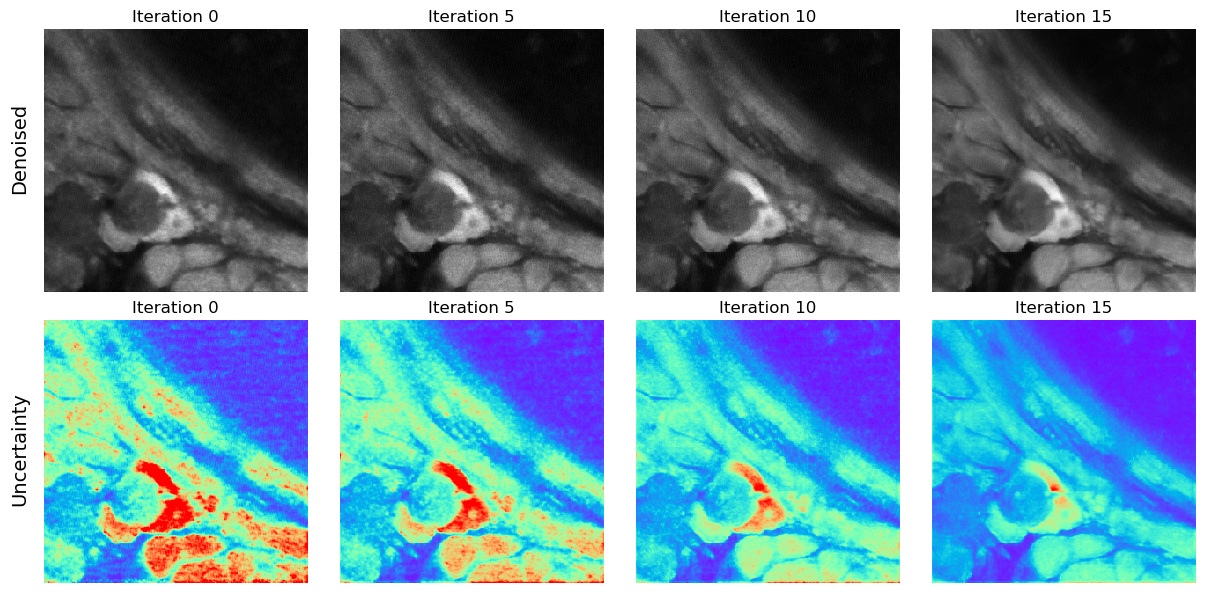

In [12]:
#Looking at Uncertainty Trends for an MPM Sample
sample = 28

denoised_sample = denoised_dict[sample]
uncertainty_sample = uncertain_dict[sample]

fig, axes = plt.subplots(2, 4, figsize=(12, 6)) 
for i in range(4):
    axes[0, i].imshow(denoised_sample[i * 5][200:500, 0:300], cmap = "gray")  
    axes[0, i].axis("off") 
    axes[0, i].set_title(f"Iteration {i * 5}")

for i in range(4):
    axes[1, i].imshow(uncertainty_sample[i * 5][200:500, 0:300], cmap="rainbow", vmax = np.max(uncertainty_sample[15]))  
    axes[1, i].axis("off")  
    axes[1, i].set_title(f"Iteration {i * 5}")

# Set y-axis labels for rows
fig.text(0.0, 0.75, "Denoised", va="center", ha="center", fontsize=14, rotation=90)
fig.text(0.0, 0.25, "Uncertainty", va="center", ha="center", fontsize=14, rotation=90)
plt.tight_layout()
plt.show()

In [13]:
#percents = list(range(0, 2, 20))
print(np.arange(0, 2, 20))

[0]


In [14]:
tot_pix_scanned = torch.tensor(noisy_dict[28][0].shape).prod().item()

# ADAPTIVE PART
sample = 28
noisy_ims_torch = noisy_dict[sample][-1]

percents =  [0.01]

adaptive_dict = {}
uncertainty_dict = {}
mse_error_list = []

with torch.no_grad():
    for percent in log_progress(percents):
        adaptive_images = []
        uncertainty_perc = []
        num_pixels_scanned = []

        # Prepare input image batch
        noisy_0 = noisy_ims_torch[0]
        in_img = noisy_0.repeat(20, 1, 1).unsqueeze(0).to(device)

        # Initial model inference
        out = finetuned(in_img.float())[0].detach().cpu()
        uncertainty_0 = torch.clamp((out[2] - out[0]) * ch4_lambdas[-1], 0, 1)

        num_pixels_scanned.append(in_img.shape[-1] ** 2)
        unc_thresh = np.percentile(uncertainty_0, percent)
        
        for i in range(1, 20):
            mask = uncertainty_0 >= unc_thresh
            noisy_now = torch.where(mask, noisy_ims_torch[i], noisy_0)
            num_pixels_scanned.append(mask.sum().item())

            in_img[0, i] = noisy_now.to(device)

            out = finetuned(in_img.float())[0].detach().cpu()
            adaptive_images.append(out[1].clone())

            uncertainty_0 = (out[2] - out[0]) * ch4_lambdas[-1]
            uncertainty_perc.append(uncertainty_0.clone())

        perc_pix_rescanned = sum(num_pixels_scanned) / tot_pix_scanned
        print("percents = ", percent)
        print("perc_pix_rescanned = ", perc_pix_rescanned)
        adaptive_dict[percent] = adaptive_images
        uncertainty_dict[percent] = uncertainty_perc

percents =  0.01
perc_pix_rescanned =  0.8078048



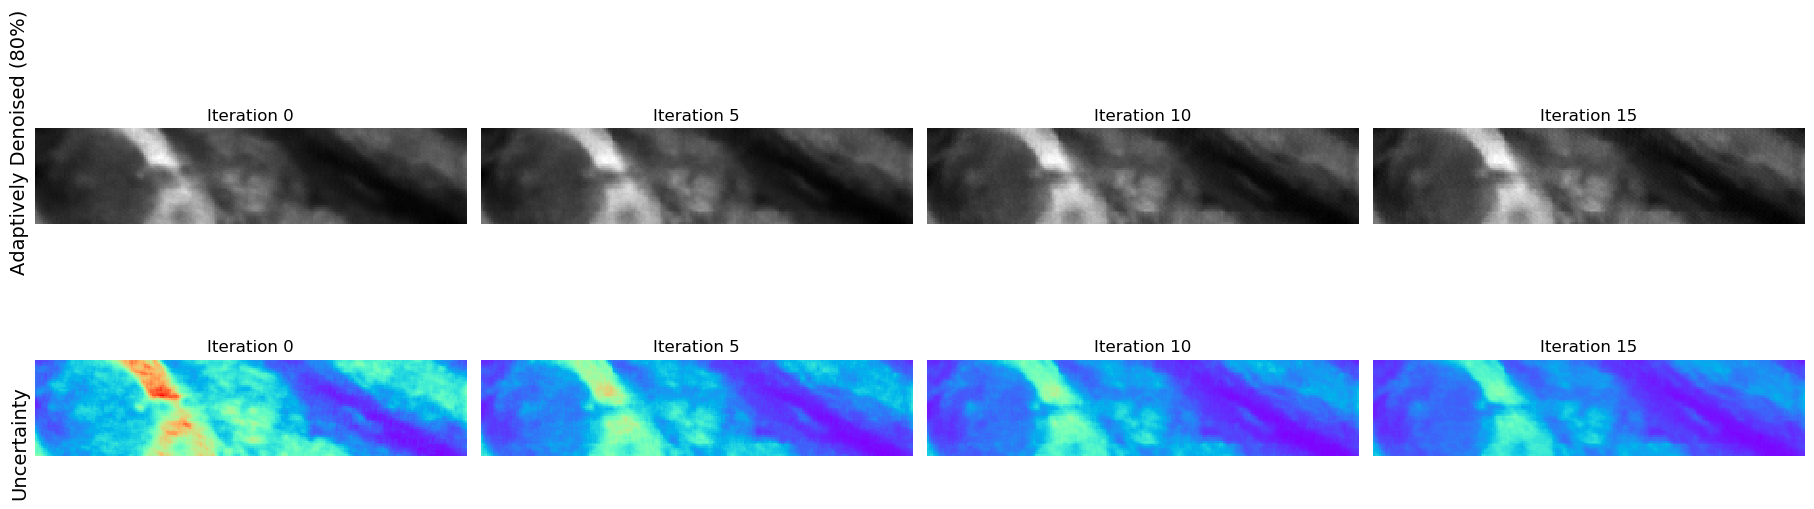

In [15]:
adaptive_perc = adaptive_dict[0.01]
uncertainty_perc = uncertainty_dict[0.01]

fig, axes = plt.subplots(2, 4, figsize=(18, 6)) 
x = 0
y = 250
for i in range(4):
    axes[0, i].imshow(adaptive_perc[i * 5][375:425, 75:300], cmap = "gray")  
    axes[0, i].axis("off") 
    axes[0, i].set_title(f"Iteration {i * 5}")

for i in range(4):
    axes[1, i].imshow(uncertainty_perc[i * 5][375:425, 75:300], cmap="rainbow", vmax = torch.max(uncertainty_perc[0]))  
    axes[1, i].axis("off")  
    axes[1, i].set_title(f"Iteration {i * 5}")

fig.text(0.0, 0.75, "Adaptively Denoised (80%)", va="center", ha="center", fontsize=14, rotation=90)
fig.text(0.0, 0.25, "Uncertainty", va="center", ha="center", fontsize=14, rotation=90)
plt.tight_layout()
plt.show()